# The goal of this document is to:

## 1. Prepare a transformed slice of bridge data for exploration and visualization. 

## 2. Prepare a transformed slice of bridge data for classification (make dummy variables, etc.)

## 3. Run CART, random forrest, and logistic regression classification models 

In [116]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from statistics import mean
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay 
from sklearn.metrics import accuracy_score
from random import randrange
import warnings
import math
from sklearn import tree
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import seaborn as sn
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.model_selection import train_test_split #from imblearn import under_sampling, over_sampling

In [117]:
#Loading PA bridge dataset and filtering out bridges outside of Allegheny County
PA22 = pd.read_csv("PA22 - PA22.csv")
PA22_allegheny = PA22[PA22["COUNTY_CODE_003"] == 3]
PA22_allegheny.head()

,STATE_CODE_001,STRUCTURE_NUMBER_008,RECORD_TYPE_005A,ROUTE_PREFIX_005B,SERVICE_LEVEL_005C,ROUTE_NUMBER_005D,DIRECTION_005E,HIGHWAY_DISTRICT_002,COUNTY_CODE_003,PLACE_CODE_004,...,BRIDGE_LEN_IND_112,SCOUR_CRITICAL_113,FUTURE_ADT_114,YEAR_OF_FUTURE_ADT_115,MIN_NAV_CLR_MT_116,FED_AGENCY,SUBMITTED_BY,BRIDGE_CONDITION,LOWEST_RATING,DECK_AREA
182,42,488,1,3,4,8,0,11,3,61000,...,Y,8,13300,2032,0.0,N,42,F,5,10462.97
183,42,491,1,3,1,8,1,11,3,24160,...,Y,N,12346,2032,0.0,N,42,F,5,1670.63
184,42,492,1,3,7,8,3,11,3,24160,...,Y,N,12878,2032,0.0,N,42,F,5,1596.00
185,42,495,1,3,1,8,0,11,3,69584,...,Y,4,25224,2032,0.0,N,42,F,5,638.82
186,42,496,1,3,1,8,0,11,3,69584,...,Y,4,25224,2032,0.0,N,42,F,5,410.04


## 1.  Prepare a transformed slice of bridge data for exploration and visualizetion. 

The dataset contains many numerical categorical variables that are not intuitive or easy to remember, we also discovered some redundancy. Although CART will require categorical data to be in numerical format, creating new categorical variables will reduce some redundancy and clarify the meaning of the features being selected. We will then create dummy variables.

In [118]:
#Variables most relevant to bridge condition prediction
relevant_variables = ['PLACE_CODE_004', 'TOLL_020', 'MAINTENANCE_021',  'FUNCTIONAL_CLASS_026', 
                     'YEAR_BUILT_027', 'TRAFFIC_LANES_ON_028A' , 'ADT_029', 'DEGREES_SKEW_034',
                      'STRUCTURE_KIND_043A', 'STRUCTURE_TYPE_043B', 'MAIN_UNIT_SPANS_045', 
                      'MAX_SPAN_LEN_MT_048', 'STRUCTURE_LEN_MT_049', 'ROADWAY_WIDTH_MT_051', 
                      'CHANNEL_COND_061', 'DATE_OF_INSPECT_090', 'INSPECT_FREQ_MONTHS_091',
                      'HIGHWAY_SYSTEM_104', 'HIGHWAY_SYSTEM_104', 'DECK_STRUCTURE_TYPE_107', 
                      'SURFACE_TYPE_108A', 'MEMBRANE_TYPE_108B', 'DECK_PROTECTION_108C', 
                      'PERCENT_ADT_TRUCK_109', 'BRIDGE_CONDITION', 'DECK_AREA']

#Creating a bridge dataset of variables for 'bridge-alone' classification models
Bridges_class = PA22_allegheny[PA22_allegheny.columns.intersection(relevant_variables)]
Bridges_class.head(n=7)


,PLACE_CODE_004,TOLL_020,MAINTENANCE_021,FUNCTIONAL_CLASS_026,YEAR_BUILT_027,TRAFFIC_LANES_ON_028A,ADT_029,DEGREES_SKEW_034,STRUCTURE_KIND_043A,STRUCTURE_TYPE_043B,...,DATE_OF_INSPECT_090,INSPECT_FREQ_MONTHS_091,HIGHWAY_SYSTEM_104,DECK_STRUCTURE_TYPE_107,SURFACE_TYPE_108A,MEMBRANE_TYPE_108B,DECK_PROTECTION_108C,PERCENT_ADT_TRUCK_109,BRIDGE_CONDITION,DECK_AREA
182,61000,3,1,14,1960,4,13887,99,4,9,...,1020,24,1,1,1,0,1,4.0,F,10462.97
183,24160,3,1,14,1960,2,16758,99,3,2,...,1020,24,1,1,1,0,1,10.0,F,1670.63
184,24160,3,1,14,1960,1,16107,99,3,2,...,1020,24,1,1,1,0,1,9.0,F,1596.00
185,69584,3,1,14,1925,4,32865,45,1,11,...,1019,24,1,N,N,N,N,10.0,F,638.82
186,69584,3,1,14,1925,4,32865,5,1,11,...,1019,24,1,N,N,N,N,10.0,F,410.04
187,69584,3,1,14,1912,4,21271,30,1,11,...,1019,24,1,N,N,N,N,9.0,F,316.80
188,69584,3,1,14,1933,4,21271,30,3,2,...,1019,24,1,1,6,0,0,9.0,F,316.59


In [119]:
Bridges_class.describe(include = 'all')
#Categorical values
#Bridges_class[['TOLL_020']].mean()

,PLACE_CODE_004,TOLL_020,MAINTENANCE_021,FUNCTIONAL_CLASS_026,YEAR_BUILT_027,TRAFFIC_LANES_ON_028A,ADT_029,DEGREES_SKEW_034,STRUCTURE_KIND_043A,STRUCTURE_TYPE_043B,...,DATE_OF_INSPECT_090,INSPECT_FREQ_MONTHS_091,HIGHWAY_SYSTEM_104,DECK_STRUCTURE_TYPE_107,SURFACE_TYPE_108A,MEMBRANE_TYPE_108B,DECK_PROTECTION_108C,PERCENT_ADT_TRUCK_109,BRIDGE_CONDITION,DECK_AREA
count,1294.00000,1294.000000,1294.000000,1294.000000,1294.000000,1294.00000,1294.000000,1294.000000,1294.000000,1294.000000,...,1294.000000,1294.000000,1294.000000,1294,1294,1294,1294,1293.000000,1294,1294.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9,9,7,7,NaN,3,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1,1,0,1,NaN,F,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,942,594,973,699,NaN,781,NaN
mean,49253.84544,2.948995,4.070325,14.506182,1965.890263,2.42813,12342.000773,26.336940,3.258887,6.070325,...,683.085781,25.569552,0.481453,NaN,NaN,NaN,NaN,6.858469,NaN,1160.069776
std,20146.21782,0.255842,7.902959,3.580199,31.424179,1.11546,15761.580475,29.987121,1.632584,5.919713,...,288.751436,5.950377,0.499849,NaN,NaN,NaN,NaN,4.700891,NaN,2237.708729
min,724.00000,1.000000,1.000000,1.000000,1841.000000,1.00000,0.000000,0.000000,0.000000,0.000000,...,120.000000,23.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,27.740000
25%,32328.00000,3.000000,1.000000,11.000000,1946.250000,2.00000,2041.000000,0.000000,2.000000,2.000000,...,518.000000,24.000000,0.000000,NaN,NaN,NaN,NaN,5.000000,NaN,132.860000
50%,56384.00000,3.000000,1.000000,14.000000,1966.000000,2.00000,6583.000000,17.000000,3.000000,3.000000,...,621.000000,24.000000,0.000000,NaN,NaN,NaN,NaN,6.000000,NaN,398.120000
75%,61000.00000,3.000000,2.000000,17.000000,1988.000000,3.00000,17445.000000,43.000000,4.000000,7.000000,...,921.000000,24.000000,1.000000,NaN,NaN,NaN,NaN,8.000000,NaN,1252.555000


In [120]:
Bridges_class.dtypes

PLACE_CODE_004               int64
TOLL_020                     int64
MAINTENANCE_021              int64
FUNCTIONAL_CLASS_026         int64
YEAR_BUILT_027               int64
TRAFFIC_LANES_ON_028A        int64
ADT_029                      int64
DEGREES_SKEW_034             int64
STRUCTURE_KIND_043A          int64
STRUCTURE_TYPE_043B          int64
MAIN_UNIT_SPANS_045          int64
MAX_SPAN_LEN_MT_048        float64
STRUCTURE_LEN_MT_049       float64
ROADWAY_WIDTH_MT_051       float64
CHANNEL_COND_061            object
DATE_OF_INSPECT_090          int64
INSPECT_FREQ_MONTHS_091      int64
HIGHWAY_SYSTEM_104           int64
DECK_STRUCTURE_TYPE_107     object
SURFACE_TYPE_108A           object
MEMBRANE_TYPE_108B          object
DECK_PROTECTION_108C        object
PERCENT_ADT_TRUCK_109      float64
BRIDGE_CONDITION            object
DECK_AREA                  float64
dtype: object

In [121]:
#Creates new column based on data dictionarys 

#TOLL_020 
Toll = {1:1, 2:1, 3:1, 4:1, 5:1}  
#MAINTENANCE_021 
#Note that more than one agency can share the responsibility of bridge maintenance, in these cases the agency 
#with the highest hieracrchy within that responsibility is listed (e.g. if both municipal and state share 
#responsibilities state will be listed). #According to the output in the chunk above, none of the bridges 
#in AC have a maintenace code above 31. For our purposes, highway and toll authority are grouped together 

Maintenance = {1: 'State', 2: 'County', 3: 'Municipal', 4: 'Municipal', 11: 'State', 12: 'Municipal', 
               21: 'State', 25: 'Municipal', 26: 'Private', 27: 'Railroad', 31: 'State', 
               32: 'Municipal'}

#FUNCTIONAL_CLASS_026
#Creating Urban category based on the FUNCTIONAL_CLASS data dictionary
Urban = {1:0,2:0,6:0,7:0,8:0,9:0,11:1,12:1,14:1,16:1,17:1,19:1}

#FUNCTIONAL_CLASS_026
Function = {1: 'Interstate Principal Arterial', 2: 'Other Principal Arterial', 6: 'Minor Arterial', 
            7: 'Major Collector', 8: 'Minor Collector', 9: 'Municipal', 11: 'Interstate Principal Arterial', 
            12: 'Other Principal Arterial Freeways', 14: 'Other Principal Arterial', 16: 'Minor Arterial',
            17: 'Collector', 19: 'Municipal'}

#STRUCTURE_KIND_043A
Structure_Kind = {1: 'Concrete', 2: 'Concrete continuous', 3: 'Steel', 4: 'Steel continuous', 5: 'Prestressed concrete', 
                  6: 'Prestressed concrete continuous', 7: 'Wood', 8: 'Masonary', 9: 'Aluminum', 0: 'Other'}

#STRUCTURE_TYPE_043B
Structure_Type = {1: 'Slab', 2: 'Stringer or Girder', 3: 'Girder and floorbeam', 4: 'Tee beam', 
                  5: 'Multiple box beams or girders', 6: 'Single box beam or girder', 7: 'Frame', 
                  8: 'Orthotropic', 9: 'Truss - Deck', 10: 'Truss - Thru', 11: 'Arch - Deck',
                  12: 'Arch - Thru', 13: 'Suspension', 14: 'Stayed Girder', 15: 'Movable - Lift',
                  16: 'Movable - Bascule', 17: 'Movable - Swing', 18: 'Tunnel', 19: 'Culvert',
                  20: 'Mixed types', 21: 'Segmental Box Girder', 22: 'Channel Beam', 0: 'Other'}

#DECK_STRUCTURE_TYPE_107
Deck = {'N': 0, '1': 1, '2': 1, '3': 1, '4': 1, '5':1, '6': 1, '7': 1, '8': 1, '9': 1}

Deck_Structure = {'N': 'No deck', '1': 'Concrete Cast-in-Place', '2': 'Concrete Precast Panels', 
                  '3': 'Open Grating', '4': 'Closed Grating', '5': 'Steel plate', '6': 'Corrugated Steel', 
                  '7': 'Aluminum', '8': 'Wood', '9': 'Other'}

#SURFACE_TYPE_108A
Surface_Type = {'N': 'No deck', '0': 'None', '1': 'Monolithic Concrete', '2': ' Integral Concrete', '3': 'Latex Concrete', 
                '4': 'Low Slump Concrete', '5': 'Epoxy Overlay', '6': 'Bituminous', '7': 'Wood', 
                '8': 'Gravel', '9': 'Other'}

#MEMBRANE_TYPE_108B
Membrane_Type = {'N': 'No deck','0': 'None', '1': 'Built-up', '2': 'Preformed Fabric', '3': 'Epoxy', '8': 'Unknown',
                 '9': 'Other'}

#DECK_PROTECTION_108C
Deck_Protect = {'N': 'No deck','0': 'None', '1': 'Epoxy Coated', '2': 'Galvanized', '3': 'Other Coated Reinforcing', 
                '4': 'Cathodic Protection', '6': 'Polymer Impregnated', '7': 'Internally Sealed', 
                '8': 'Unknown', '9': 'Other', }

In [122]:
#Using dictionaries to create new columns that are easier to interpret for the reader
new_variables = [ 'Age', 'Toll','Urban','Maintenance', 'Function', 'Structure_Kind', 'Structure_Type', 
                 'Deck_Structure', 'Surface_Type', 'Membrane_Type', 'Deck_Protect', 'Deck']

Bridges_class['Toll'] = Bridges_class['TOLL_020'].map(Toll)
Bridges_class['Maintenance'] = Bridges_class['MAINTENANCE_021'].map(Maintenance)
Bridges_class['Urban'] = Bridges_class['FUNCTIONAL_CLASS_026'].map(Urban)
Bridges_class['Function'] = Bridges_class['FUNCTIONAL_CLASS_026'].map(Function)
Bridges_class['Structure_Kind'] = Bridges_class['STRUCTURE_KIND_043A'].map(Structure_Kind)
Bridges_class['Structure_Type'] = Bridges_class['STRUCTURE_TYPE_043B'].map(Structure_Type)
Bridges_class['Deck_Structure'] = Bridges_class['DECK_STRUCTURE_TYPE_107'].map(Deck_Structure)
Bridges_class['Deck'] = Bridges_class['DECK_STRUCTURE_TYPE_107'].map(Deck)
Bridges_class['Surface_Type'] = Bridges_class['SURFACE_TYPE_108A'].map(Surface_Type)
Bridges_class['Membrane_Type'] = Bridges_class['MEMBRANE_TYPE_108B'].map(Membrane_Type)
Bridges_class['Deck_Protect'] = Bridges_class['DECK_PROTECTION_108C'].map(Deck_Protect)
Bridges_class['Age'] = 2022 - Bridges_class['YEAR_BUILT_027']

Bridges_class[Bridges_class.columns.intersection(new_variables)].head()

,Toll,Maintenance,Urban,Function,Structure_Kind,Structure_Type,Deck_Structure,Deck,Surface_Type,Membrane_Type,Deck_Protect,Age
182,1,State,1,Other Principal Arterial,Steel continuous,Truss - Deck,Concrete Cast-in-Place,1,Monolithic Concrete,None,Epoxy Coated,62
183,1,State,1,Other Principal Arterial,Steel,Stringer or Girder,Concrete Cast-in-Place,1,Monolithic Concrete,None,Epoxy Coated,62
184,1,State,1,Other Principal Arterial,Steel,Stringer or Girder,Concrete Cast-in-Place,1,Monolithic Concrete,None,Epoxy Coated,62
185,1,State,1,Other Principal Arterial,Concrete,Arch - Deck,No deck,0,No deck,No deck,No deck,97
186,1,State,1,Other Principal Arterial,Concrete,Arch - Deck,No deck,0,No deck,No deck,No deck,97


In [123]:
Bridges_class['DATE_OF_INSPECT_090']

182      1020
183      1020
184      1020
185      1019
186      1019
         ... 
23023    1220
23036    1120
23078     420
23127    1021
23130    1121
Name: DATE_OF_INSPECT_090, Length: 1294, dtype: int64

In [124]:
#convert DATE_OF_INSPECT_090_test to datetime object
Bridges_class['DATE_OF_INSPECT_090']=pd.to_datetime(Bridges_class['DATE_OF_INSPECT_090'], format='%m%y')                                                      

In [125]:
#Change new categorical variable into category data type 
category_vars = ['Maintenance', 'Function', 'Structure_Kind', 'Structure_Type', 'Deck_Structure', 'Surface_Type', 
                'Membrane_Type', 'Deck_Protect'] 
#Values need to be 'category' dtype to make dummy variables

for var in category_vars:
     Bridges_class[var] = Bridges_class[var].astype('category')
Bridges_class[Bridges_class.columns.intersection(category_vars)].head()

,Maintenance,Function,Structure_Kind,Structure_Type,Deck_Structure,Surface_Type,Membrane_Type,Deck_Protect
182,State,Other Principal Arterial,Steel continuous,Truss - Deck,Concrete Cast-in-Place,Monolithic Concrete,None,Epoxy Coated
183,State,Other Principal Arterial,Steel,Stringer or Girder,Concrete Cast-in-Place,Monolithic Concrete,None,Epoxy Coated
184,State,Other Principal Arterial,Steel,Stringer or Girder,Concrete Cast-in-Place,Monolithic Concrete,None,Epoxy Coated
185,State,Other Principal Arterial,Concrete,Arch - Deck,No deck,No deck,No deck,No deck
186,State,Other Principal Arterial,Concrete,Arch - Deck,No deck,No deck,No deck,No deck


In [126]:
#List of all variables that will be considered for classification. See report.  
all_variables = new_variables + ['PLACE_CODE_004','TRAFFIC_LANES_ON_028A' , 'ADT_029', 'DEGREES_SKEW_034', 
                                 'MAX_SPAN_LEN_MT_048', 'STRUCTURE_LEN_MT_049', 'ROADWAY_WIDTH_MT_051', 
                                 'MAIN_UNIT_SPANS_045','INSPECT_FREQ_MONTHS_091','HIGHWAY_SYSTEM_104', 
                                 'PERCENT_ADT_TRUCK_109', 'BRIDGE_CONDITION', 'DECK_AREA'] 

                                    
Bridges_class_v2 = Bridges_class[Bridges_class.columns.intersection(all_variables)]
Bridges_class_v2.head()
#MAX_SPAN_LEN_MT_048, STRUCTURE_LEN_MT_049, ROADWAY_WIDTH_MT_051 and others need to be transformed because last digit is a tenth
# For example Length of Maximum Span 35.5 meters 00355

,PLACE_CODE_004,TRAFFIC_LANES_ON_028A,ADT_029,DEGREES_SKEW_034,MAIN_UNIT_SPANS_045,MAX_SPAN_LEN_MT_048,STRUCTURE_LEN_MT_049,ROADWAY_WIDTH_MT_051,INSPECT_FREQ_MONTHS_091,HIGHWAY_SYSTEM_104,...,Urban,Function,Structure_Kind,Structure_Type,Deck_Structure,Deck,Surface_Type,Membrane_Type,Deck_Protect,Age
182,61000,4,13887,99,4,121.9,641.9,15.2,24,1,...,1,Other Principal Arterial,Steel continuous,Truss - Deck,Concrete Cast-in-Place,1,Monolithic Concrete,None,Epoxy Coated,62
183,24160,2,16758,99,11,26.8,235.3,6.0,24,1,...,1,Other Principal Arterial,Steel,Stringer or Girder,Concrete Cast-in-Place,1,Monolithic Concrete,None,Epoxy Coated,62
184,24160,1,16107,99,11,25.9,212.8,6.4,24,1,...,1,Other Principal Arterial,Steel,Stringer or Girder,Concrete Cast-in-Place,1,Monolithic Concrete,None,Epoxy Coated,62
185,69584,4,32865,45,1,21.0,33.8,15.3,24,1,...,1,Other Principal Arterial,Concrete,Arch - Deck,No deck,0,No deck,No deck,No deck,97
186,69584,4,32865,5,1,20.4,20.4,17.5,24,1,...,1,Other Principal Arterial,Concrete,Arch - Deck,No deck,0,No deck,No deck,No deck,97


In [127]:
#All continuous variables have to be normalized: ADT_029, DEGREES_SKEW_034,MAIN_UNIT_SPANS_045, MAX_SPAN_LEN_MT_048,
#ROADWAY_WIDTH_MT_051, etc
continous_var = ['Age','ADT_029', 'DEGREES_SKEW_034', 'TRAFFIC_LANES_ON_028A', 'MAIN_UNIT_SPANS_045', 
                 'MAX_SPAN_LEN_MT_048', 'ROADWAY_WIDTH_MT_051', 'STRUCTURE_LEN_MT_049', 'DECK_AREA', 
                 'INSPECT_FREQ_MONTHS_091', 'PERCENT_ADT_TRUCK_109']

def normalize(df, features):
    for feature_name in features:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        df[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return df

Bridges_class_norm = normalize(Bridges_class_v2, continous_var)


In [128]:
Bridges_class_norm.describe(include='all')

,PLACE_CODE_004,TRAFFIC_LANES_ON_028A,ADT_029,DEGREES_SKEW_034,MAIN_UNIT_SPANS_045,MAX_SPAN_LEN_MT_048,STRUCTURE_LEN_MT_049,ROADWAY_WIDTH_MT_051,INSPECT_FREQ_MONTHS_091,HIGHWAY_SYSTEM_104,...,Urban,Function,Structure_Kind,Structure_Type,Deck_Structure,Deck,Surface_Type,Membrane_Type,Deck_Protect,Age
count,1294.00000,1294.000000,1294.000000,1294.000000,1294.000000,1294.000000,1294.000000,1294.000000,1294.000000,1294.000000,...,1294.000000,1294,1294,1294,1294,1294.000000,1294,1294,1294,1294.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,8,10,16,9,NaN,9,7,7,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Municipal,Steel,Stringer or Girder,Concrete Cast-in-Place,NaN,Monolithic Concrete,None,Epoxy Coated,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,361,401,563,942,NaN,594,973,699,NaN
mean,49253.84544,0.204019,0.117318,0.266030,0.037205,0.107884,0.053992,0.223325,0.102782,0.481453,...,0.926584,NaN,NaN,NaN,NaN,0.782071,NaN,NaN,NaN,0.306165
std,20146.21782,0.159351,0.149823,0.302900,0.083232,0.128426,0.096896,0.131334,0.238015,0.499849,...,0.260919,NaN,NaN,NaN,NaN,0.412998,NaN,NaN,NaN,0.174579
min,724.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000
25%,32328.00000,0.142857,0.019401,0.000000,0.000000,0.027050,0.003336,0.155650,0.040000,0.000000,...,1.000000,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,0.183333
50%,56384.00000,0.142857,0.062575,0.171717,0.000000,0.069738,0.015230,0.208955,0.040000,0.000000,...,1.000000,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,0.305556
75%,61000.00000,0.285714,0.165825,0.434343,0.057143,0.135249,0.056295,0.272921,0.040000,1.000000,...,1.000000,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,0.415278


<AxesSubplot:>

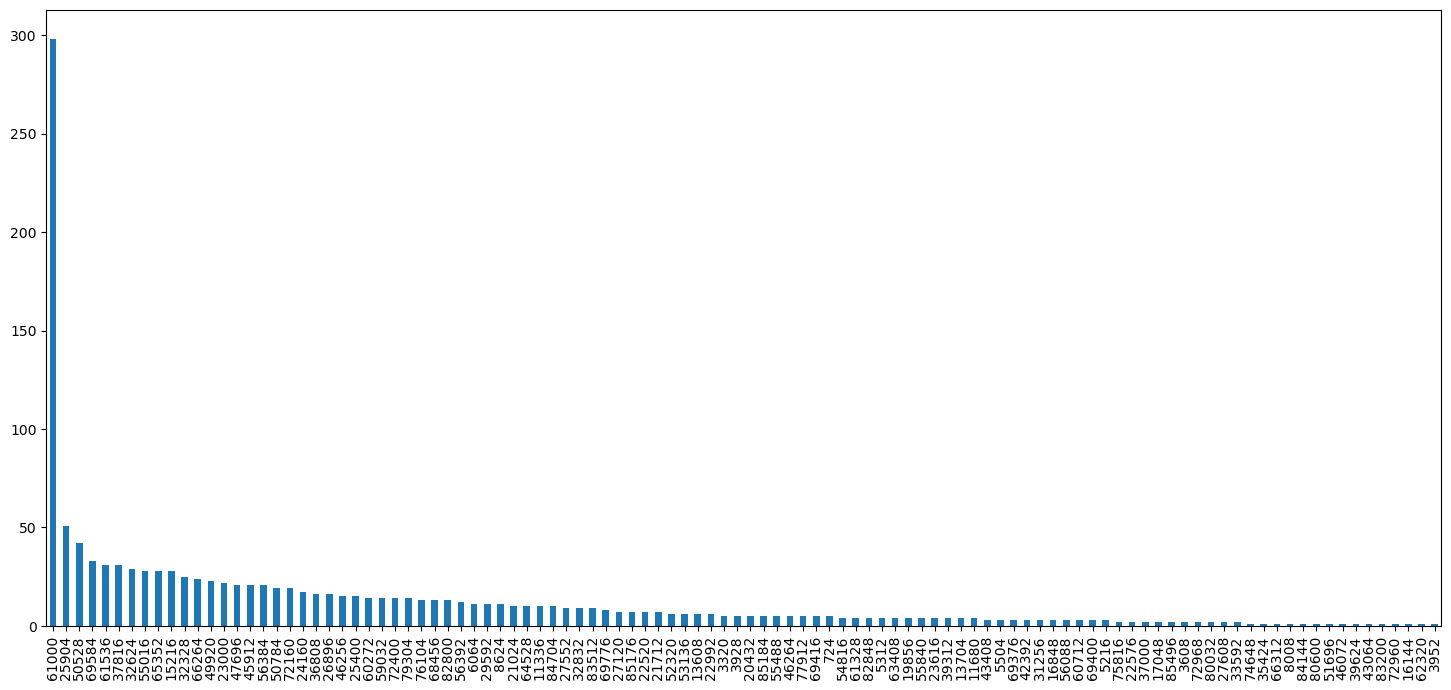

In [129]:
Bridges_class_norm['PLACE_CODE_004'].value_counts().plot(kind='bar', figsize=(18,8)) #Number of bridges by place code

Text(0, 0.5, 'Frequency')

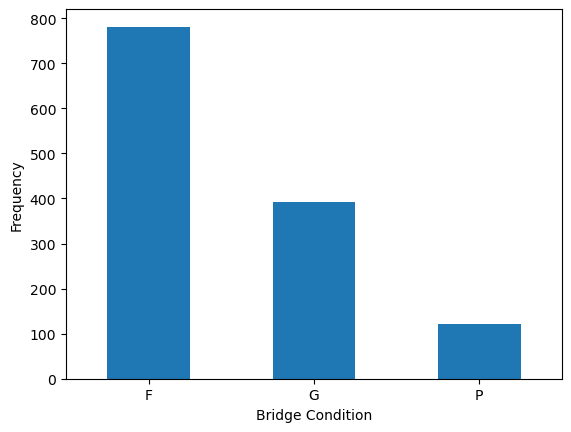

In [157]:
#plt.figure(figsize=(8,8))
fig = Bridges_class_norm['BRIDGE_CONDITION'].value_counts().plot.bar(rot=0) #bridges by condition
fig.set_xlabel("Bridge Condition")
fig.set_ylabel("Frequency")



<AxesSubplot:>

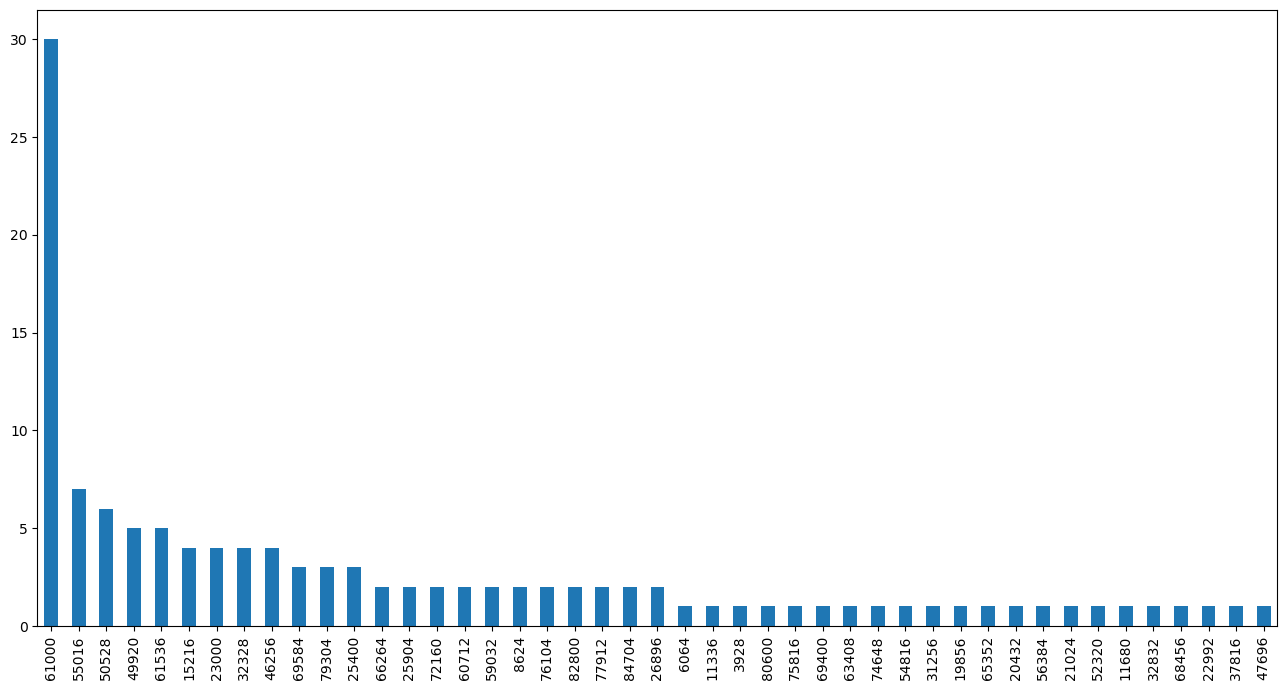

In [131]:
poor_bridges = Bridges_class_norm.loc[Bridges_class_norm['BRIDGE_CONDITION'] == 'P'] #bridges with poor bridge condition rating
poor_bridges['PLACE_CODE_004'].value_counts().plot(kind='bar', figsize=(16,8)) #poor bridges by place (FIPS municipality code)

In [62]:
#Bridges_class_norm['Membrane_Type'].unique()  #Checking membrane type 

# 2. Data prep for classification models

In [132]:
dummy_vars = ['Maintenance', 'Function', 'Structure_Kind', 'Structure_Type', 'Deck_Structure', 
              'Surface_Type', 'Membrane_Type', 'Deck_Protect']
drop_columns = ['PLACE_CODE_004']
def prep_bridge_class_norm(df, dummy_vars, drop_columns):
    df = df.drop(columns = drop_columns) 
    result = {'P':0, 'F':1, 'G':2}  #Poor bridges are 0, fair are 1, good are 2
    df['BRIDGE_CONDITION'] = df['BRIDGE_CONDITION'].astype('string')
    df['BRIDGE_CONDITION'] = df['BRIDGE_CONDITION'].map(result)
    df['BRIDGE_CONDITION'] = df['BRIDGE_CONDITION'].astype('uint8')
    df['PERCENT_ADT_TRUCK_109'] = df['PERCENT_ADT_TRUCK_109'].fillna(0) #missing percent average dailt traffic truck is 0
    all_variables = list(df.columns)
    other_vars = [x for x in all_variables if x not in dummy_vars]
    df2 = pd.get_dummies(df[dummy_vars])
    df3 = pd.concat([df[other_vars], df2], axis=1) #concatenates continous variables with dummy variables
    return df3

In [133]:
df = prep_bridge_class_norm(Bridges_class_norm, dummy_vars, drop_columns)

#Function creates a correlation matrix and displays
def corr_check(df):
    corr_mat = df.corr().abs()
    sorted_mat = corr_mat.unstack().sort_values(ascending=False)
    print (sorted_mat.head(n=60))

In [134]:
corr_check(df)  #Identify highly correlated/redundant variables

Deck_Structure_No deck                          Deck                                              1.0
Deck                                            Deck_Structure_No deck                            1.0
TRAFFIC_LANES_ON_028A                           TRAFFIC_LANES_ON_028A                             1.0
Function_Minor Arterial                         Function_Minor Arterial                           1.0
Function_Municipal                              Function_Municipal                                1.0
Function_Other Principal Arterial               Function_Other Principal Arterial                 1.0
Function_Other Principal Arterial Freeways      Function_Other Principal Arterial Freeways        1.0
Structure_Kind_Aluminum                         Structure_Kind_Aluminum                           1.0
Structure_Kind_Concrete                         Structure_Kind_Concrete                           1.0
Structure_Kind_Concrete continuous              Structure_Kind_Concrete continuous

### Removes some of the highly correlated values

In [135]:
df.drop(columns = ['Deck_Structure_No deck']) #Removing redundant variable

,TRAFFIC_LANES_ON_028A,ADT_029,DEGREES_SKEW_034,MAIN_UNIT_SPANS_045,MAX_SPAN_LEN_MT_048,STRUCTURE_LEN_MT_049,ROADWAY_WIDTH_MT_051,INSPECT_FREQ_MONTHS_091,HIGHWAY_SYSTEM_104,PERCENT_ADT_TRUCK_109,...,Membrane_Type_Other,Membrane_Type_Preformed Fabric,Membrane_Type_Unknown,Deck_Protect_Epoxy Coated,Deck_Protect_Galvanized,Deck_Protect_No deck,Deck_Protect_None,Deck_Protect_Other,Deck_Protect_Other Coated Reinforcing,Deck_Protect_Unknown
182,0.428571,0.132004,1.000000,0.085714,0.503804,0.461092,0.324094,0.04,1,0.08,...,0,0,0,1,0,0,0,0,0,0
183,0.142857,0.159295,1.000000,0.285714,0.101860,0.166219,0.127932,0.04,1,0.20,...,0,0,0,1,0,0,0,0,0,0
184,0.000000,0.153107,1.000000,0.285714,0.098056,0.149902,0.136461,0.04,1,0.18,...,0,0,0,1,0,0,0,0,0,0
185,0.428571,0.312402,0.454545,0.000000,0.077346,0.020088,0.326226,0.04,1,0.20,...,0,0,0,0,0,1,0,0,0,0
186,0.428571,0.312402,0.050505,0.000000,0.074810,0.010371,0.373134,0.04,1,0.20,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23023,0.142857,0.000010,0.000000,0.057143,0.330093,0.147654,0.260128,0.04,0,0.00,...,0,0,0,1,0,0,0,0,0,0
23036,0.142857,0.041787,0.353535,0.028571,0.128910,0.038436,0.208955,0.04,0,0.10,...,0,0,0,1,0,0,0,0,0,0
23078,0.142857,0.507685,0.000000,1.000000,0.058326,0.425049,0.200426,0.04,1,0.12,...,0,0,0,1,0,0,0,0,0,0
23127,0.428571,0.281195,0.666667,0.028571,0.155959,0.054391,0.390192,0.04,1,0.48,...,0,0,0,1,0,0,0,0,0,0


In [136]:
for var in list(df.columns):   #Checks for any columns remaining that are not in the correct format (numerical)
    print(var, df[var].dtypes) 


TRAFFIC_LANES_ON_028A float64
ADT_029 float64
DEGREES_SKEW_034 float64
MAIN_UNIT_SPANS_045 float64
MAX_SPAN_LEN_MT_048 float64
STRUCTURE_LEN_MT_049 float64
ROADWAY_WIDTH_MT_051 float64
INSPECT_FREQ_MONTHS_091 float64
HIGHWAY_SYSTEM_104 int64
PERCENT_ADT_TRUCK_109 float64
BRIDGE_CONDITION uint8
DECK_AREA float64
Toll int64
Urban int64
Deck int64
Age float64
Maintenance_County uint8
Maintenance_Municipal uint8
Maintenance_Private uint8
Maintenance_Railroad uint8
Maintenance_State uint8
Function_Collector uint8
Function_Interstate Principal Arterial uint8
Function_Major Collector uint8
Function_Minor Arterial uint8
Function_Minor Collector uint8
Function_Municipal uint8
Function_Other Principal Arterial uint8
Function_Other Principal Arterial Freeways uint8
Structure_Kind_Aluminum uint8
Structure_Kind_Concrete uint8
Structure_Kind_Concrete continuous uint8
Structure_Kind_Masonary uint8
Structure_Kind_Other uint8
Structure_Kind_Prestressed concrete uint8
Structure_Kind_Prestressed concrete

In [137]:
df['BRIDGE_CONDITION'].unique()
df.groupby(['BRIDGE_CONDITION'])['BRIDGE_CONDITION'].count()

BRIDGE_CONDITION
0    122
1    781
2    391
Name: BRIDGE_CONDITION, dtype: int64

### We were concerned that the relatively low 'poor' condition observations may skew the results of the algorithms; in attempt to address this limitation we attempted to oversample with SMOTE 

In [138]:
y = df.loc[:, df.columns =='BRIDGE_CONDITION']
X = df.loc[:, df.columns!= 'BRIDGE_CONDITION']
# transform the dataset
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
# summarize distribution
counter = Counter(y)
y.groupby(['BRIDGE_CONDITION'])['BRIDGE_CONDITION'].count()
#our classes should now be balanced between bridge conditions

BRIDGE_CONDITION
0    781
1    781
2    781
Name: BRIDGE_CONDITION, dtype: int64

Text(0, 0.5, 'Frequency')

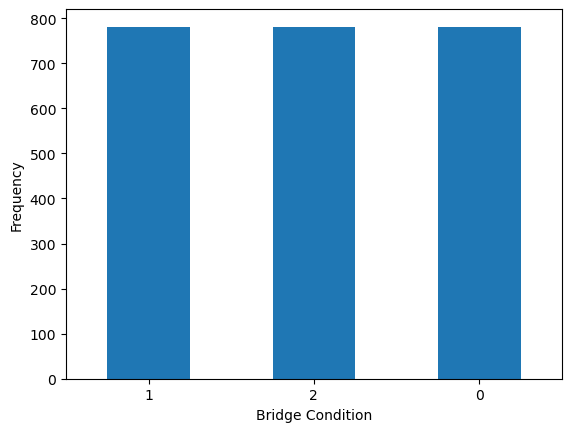

In [158]:
fig = y['BRIDGE_CONDITION'].value_counts().plot.bar(rot=0) #bridges by condition
fig.set_xlabel("Bridge Condition")
fig.set_ylabel("Frequency")

# 3.1 Random Forrest

In [165]:
def evaluate_randomforrest(df):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)
    columns = X_train.columns
    #oversampling with SMOTE
    oversample = SMOTE()
    os_data_X,os_data_y=oversample.fit_resample(X_train, y_train)
    X_train = pd.DataFrame(data=os_data_X,columns=columns)
    y_train= pd.DataFrame(data=os_data_y,columns=['BRIDGE_CONDITION'])
    gsc = GridSearchCV(estimator=RandomForestClassifier(),
                       param_grid={'max_depth': range(2,9),
                                   'n_estimators': [3, 4, 5, 6, 7, 8, 9, 10, 30, 50, 100],
                                   'min_samples_split': range(2,10)},
                       cv = 5, #Default in function is 5, but kept this line for clarity 
                       scoring = 'accuracy', 
                       verbose = False,                         
                       n_jobs = 1)
    grid_result = gsc.fit(X_train, y_train)
    best_params = grid_result.best_params_
    best_tree = grid_result.best_estimator_
    plt.figure(figsize=(60,30))
    tree.plot_tree(grid_result.best_estimator_.estimators_[0], 
                   class_names=["Poor", "Fair", "Good"],
                   filled = True, 
                   rounded = True,
                   feature_names = X.columns, 
                   fontsize = 9)
    list_of_tuples = list(zip(X.columns, best_tree.feature_importances_))
    df2 = pd.DataFrame(list_of_tuples, columns = ['Feature', 'Importance'])
    print(df2.nlargest(10, 'Importance')) #Find top 10 features by importance
    model = RandomForestClassifier(max_depth=best_params["max_depth"], 
                                n_estimators=best_params["n_estimators"],
                                min_samples_split=best_params["min_samples_split"],
                                random_state=1, 
                                verbose=False)# K-Fold CV
    print('The best parameters are', best_params, '\n')
    #fit the model
    model.fit(X_train, y_train)
    # make predictions
    yhat1 = model.predict(X_test)
    # evaluate predictions
    accuracy_score_test1 = accuracy_score(y_test, yhat1)
    print('Accuracy score for test data is: %.3f' % accuracy_score_test1)
    yhat2 = model.predict(X_train)
    # evaluate predictions
    accuracy_score_test2 = accuracy_score(y_train, yhat2)
    print('Accuracy score for train data is: %.3f' % accuracy_score_test2)
    # View the classification report for test data and predictions
    print("\nClassification Report: \n \n", classification_report(y_test, yhat1))
    cm_bridge = confusion_matrix(y_test,yhat1)
    #Graphically display confusion matricx
    display_cm_bridge= ConfusionMatrixDisplay(confusion_matrix=cm_bridge, 
                                              display_labels=['Poor (0)',
                                                              'Fair (1)',
                                                             'Good (2)'])
    display_cm_bridge.plot()

                             Feature  Importance
14                               Age    0.167927
79         Deck_Protect_Epoxy Coated    0.072044
64           Surface_Type_Bituminous    0.069189
82                 Deck_Protect_None    0.041794
68  Surface_Type_Monolithic Concrete    0.037802
19                 Maintenance_State    0.037455
4                MAX_SPAN_LEN_MT_048    0.035974
10                         DECK_AREA    0.034201
1                            ADT_029    0.032942
9              PERCENT_ADT_TRUCK_109    0.032075
The best parameters are {'max_depth': 8, 'min_samples_split': 3, 'n_estimators': 100} 

Accuracy score for test data is: 0.836
Accuracy score for train data is: 0.924

Classification Report: 
 
               precision    recall  f1-score   support

           0       0.89      0.95      0.92       235
           1       0.78      0.73      0.75       235
           2       0.84      0.82      0.83       233

    accuracy                           0.84     

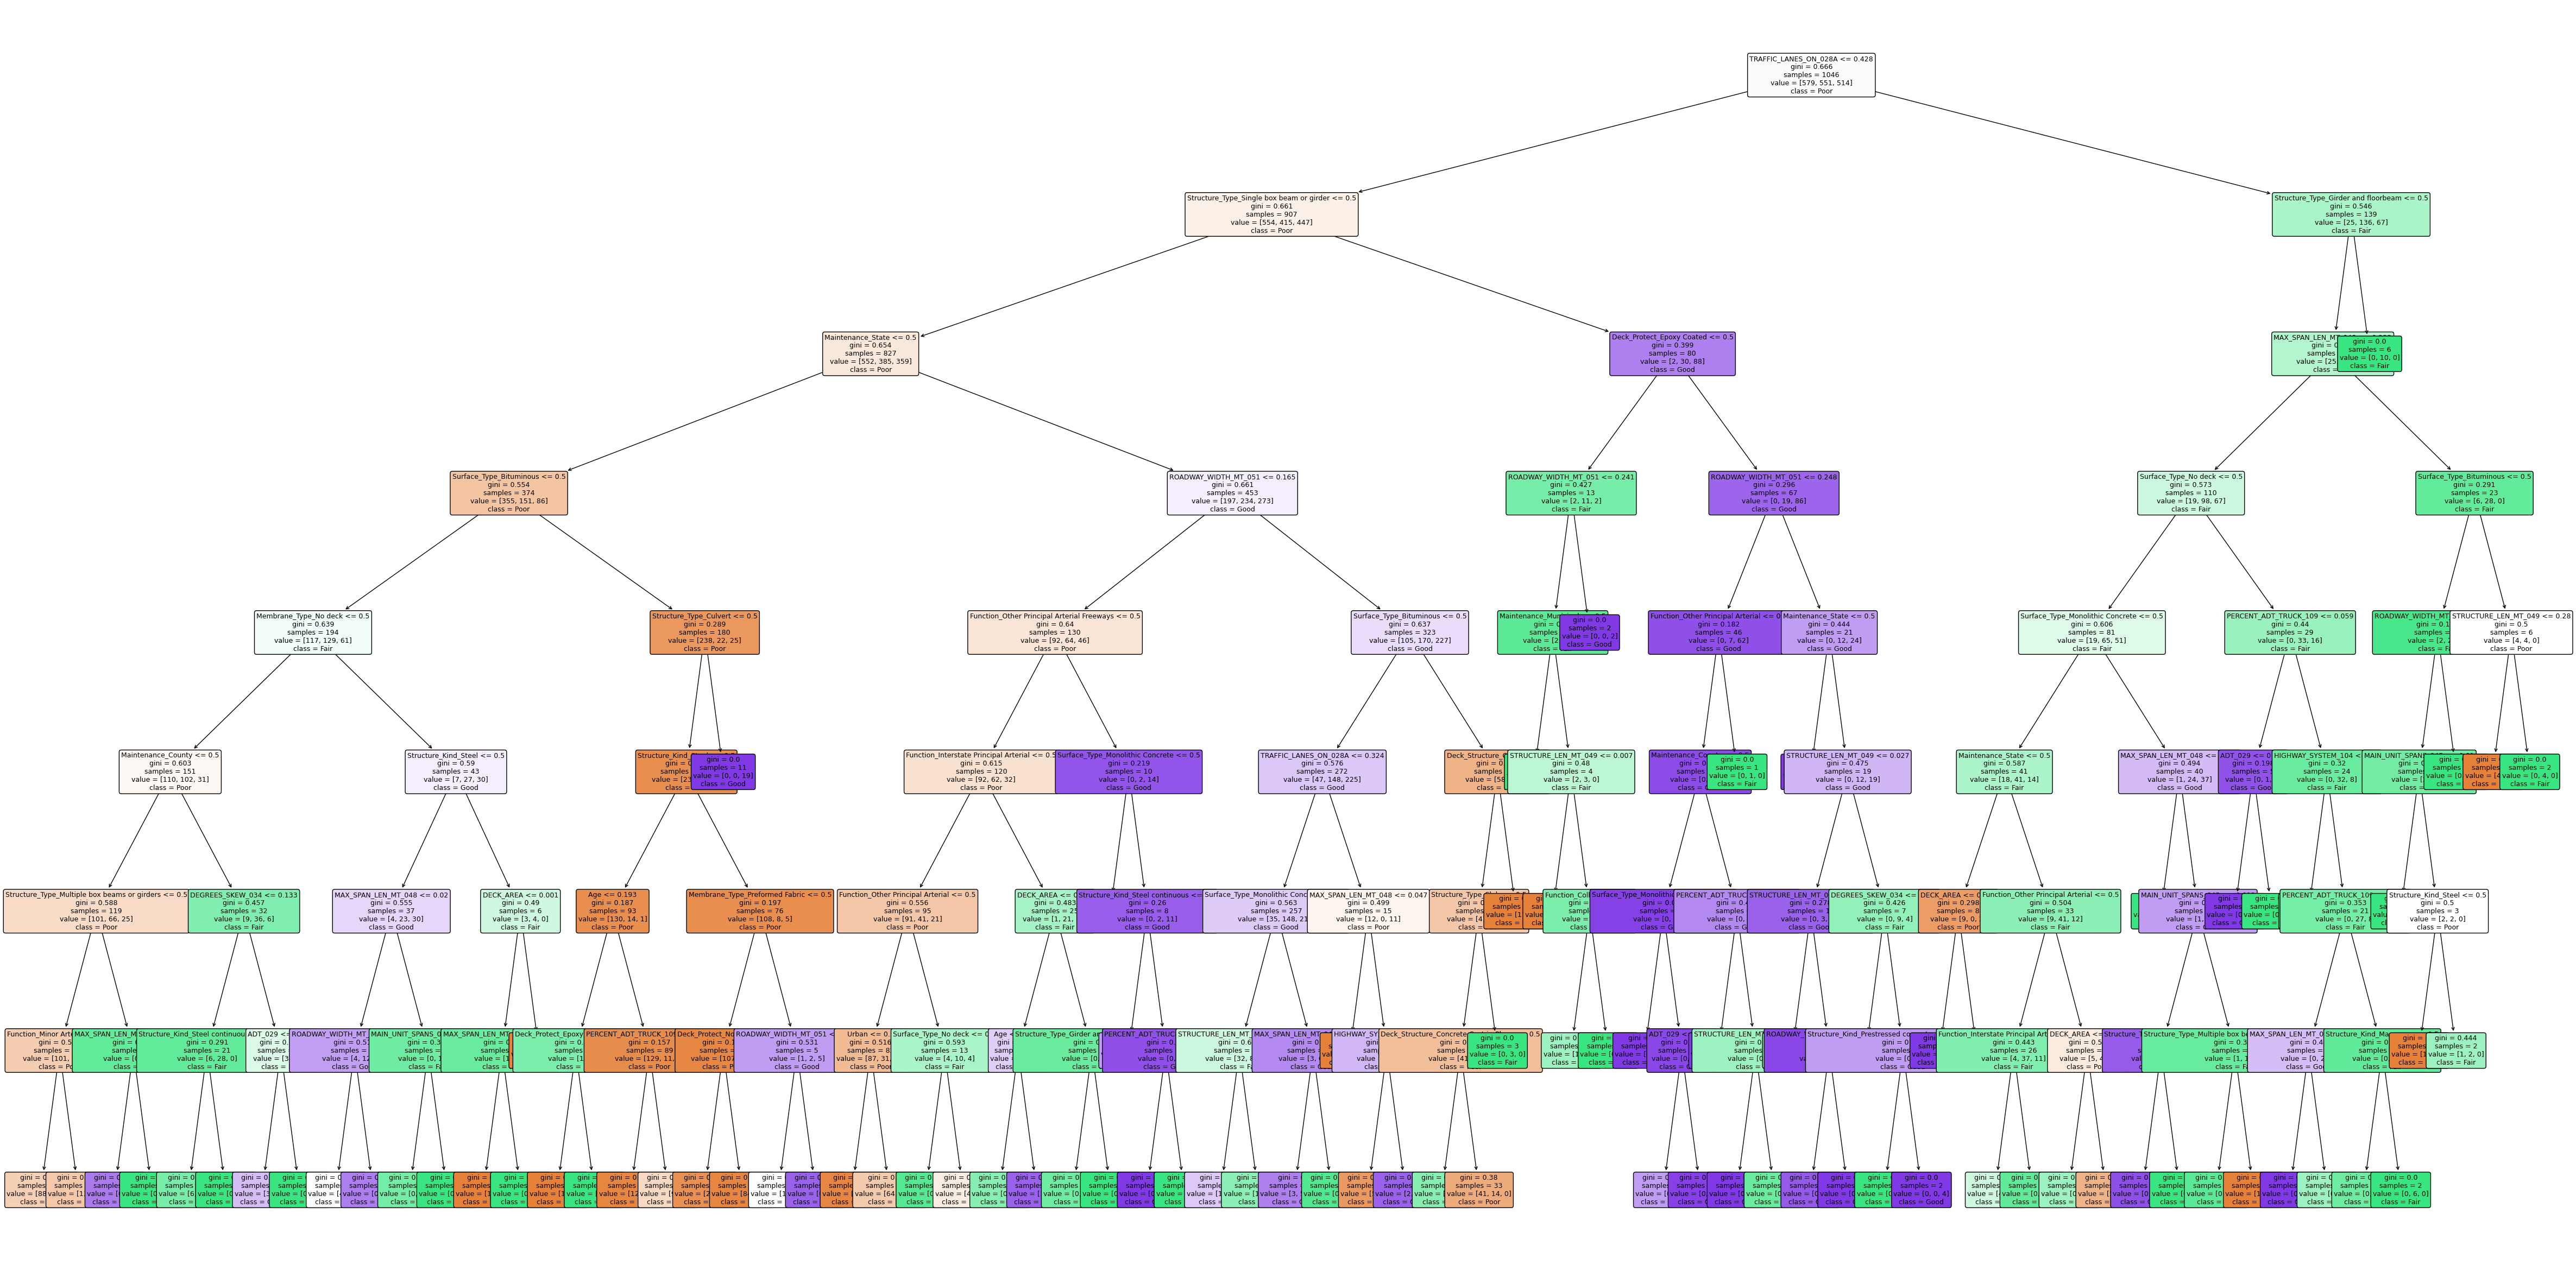

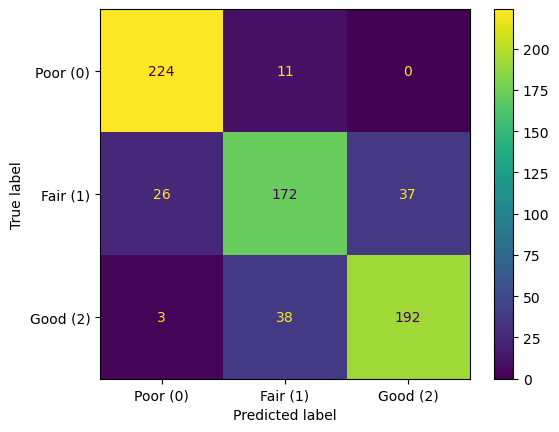

In [166]:
evaluate_randomforrest(df)


# 3.2 CART model

In [167]:
#CART model function takes data, splits into test and train. Oversamples the train data, does hypertuning, 
#Picks the best model according to hypertuning results, then tests. 
def evaluate_CART(df):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)
    columns = X_train.columns
    #oversampling with SMOTE
    oversample = SMOTE()
    os_data_X,os_data_y=oversample.fit_resample(X_train, y_train)
    X_train = pd.DataFrame(data=os_data_X,columns=columns)
    y_train= pd.DataFrame(data=os_data_y,columns=['BRIDGE_CONDITION'])
    DecisionTree_for_GridSearch = DecisionTreeClassifier(random_state = 5)
    tree_gsearch = GridSearchCV(estimator = DecisionTree_for_GridSearch, 
                     param_grid = {"criterion" : ["gini", "entropy"], #Criterion indicates the function to measure the quality of a split
                                   "max_depth" : range(1,10), #Maximum depth of the tree
                                   "min_samples_leaf" : [2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, None], #Minumum per leaf
                                   'min_samples_split': range(2,10)}, #The minimum number of obv per leaf node
                     cv = 5,  #CV will divide data randomly into 5 and cross validate
                     scoring = "accuracy")
    tree_gsearch.fit(X_train, y_train)
    best_params = tree_gsearch.best_params_
    best_score = tree_gsearch.best_score_
    print("The best parameters found are:", best_params, '\n')
    best_tree = tree_gsearch.best_estimator_
    model = DecisionTreeClassifier(random_state = 5,
                                   criterion = best_params['criterion'],
                                   max_depth=best_params["max_depth"], 
                                   min_samples_leaf=best_params["min_samples_leaf"],
                                   min_samples_split=best_params["min_samples_split"])
    list_of_tuples = list(zip(X.columns, best_tree.feature_importances_))
    df2 = pd.DataFrame(list_of_tuples, columns = ['Feature', 'Importance'])
    print(df2.nlargest(10, 'Importance')) #Find top 10 features by importance
    tree_fig = plt.figure(figsize=(60,40))
    _ = tree.plot_tree(decision_tree = best_tree,
                       filled=True,
                       rounded=True,
                       class_names=["Poor", "Fair", "Good"],
                       feature_names = X.columns, 
                       fontsize = 9); 
    _
    #fit the model
    model.fit(X_train, y_train)
    # get accuracy
    accuracy_score_test1 = model.score(X_test, y_test)
    print('Accuracy score for test data is: %.3f' % accuracy_score_test1)
    accuracy_score_test2 = model.score(X_train, y_train)
    print('Accuracy score for train data is: %.3f' % accuracy_score_test2)
    # make predictions
    yhat1 = model.predict(X_test)
    # View the classification report for test data and predictions
    print("\nClassification Report \n", classification_report(y_test, yhat1))
    matrix = confusion_matrix(y_test,yhat1)
    #print( "Confusion Matrix \n", matrix)
    ConfusionMatrixDisplay.from_predictions(y_test, yhat1)

The best parameters found are: {'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 3, 'min_samples_split': 9} 

                                  Feature  Importance
14                                    Age    0.347248
64                Surface_Type_Bituminous    0.148271
16                  Maintenance_Municipal    0.069363
9                   PERCENT_ADT_TRUCK_109    0.062813
79              Deck_Protect_Epoxy Coated    0.055133
29                Structure_Kind_Concrete    0.046831
3                     MAIN_UNIT_SPANS_045    0.042047
6                    ROADWAY_WIDTH_MT_051    0.033830
68       Surface_Type_Monolithic Concrete    0.029795
55  Deck_Structure_Concrete Cast-in-Place    0.019759
Accuracy score for test data is: 0.791
Accuracy score for train data is: 0.877

Classification Report 
               precision    recall  f1-score   support

           0       0.84      0.90      0.87       235
           1       0.71      0.71      0.71       235
           2       0.

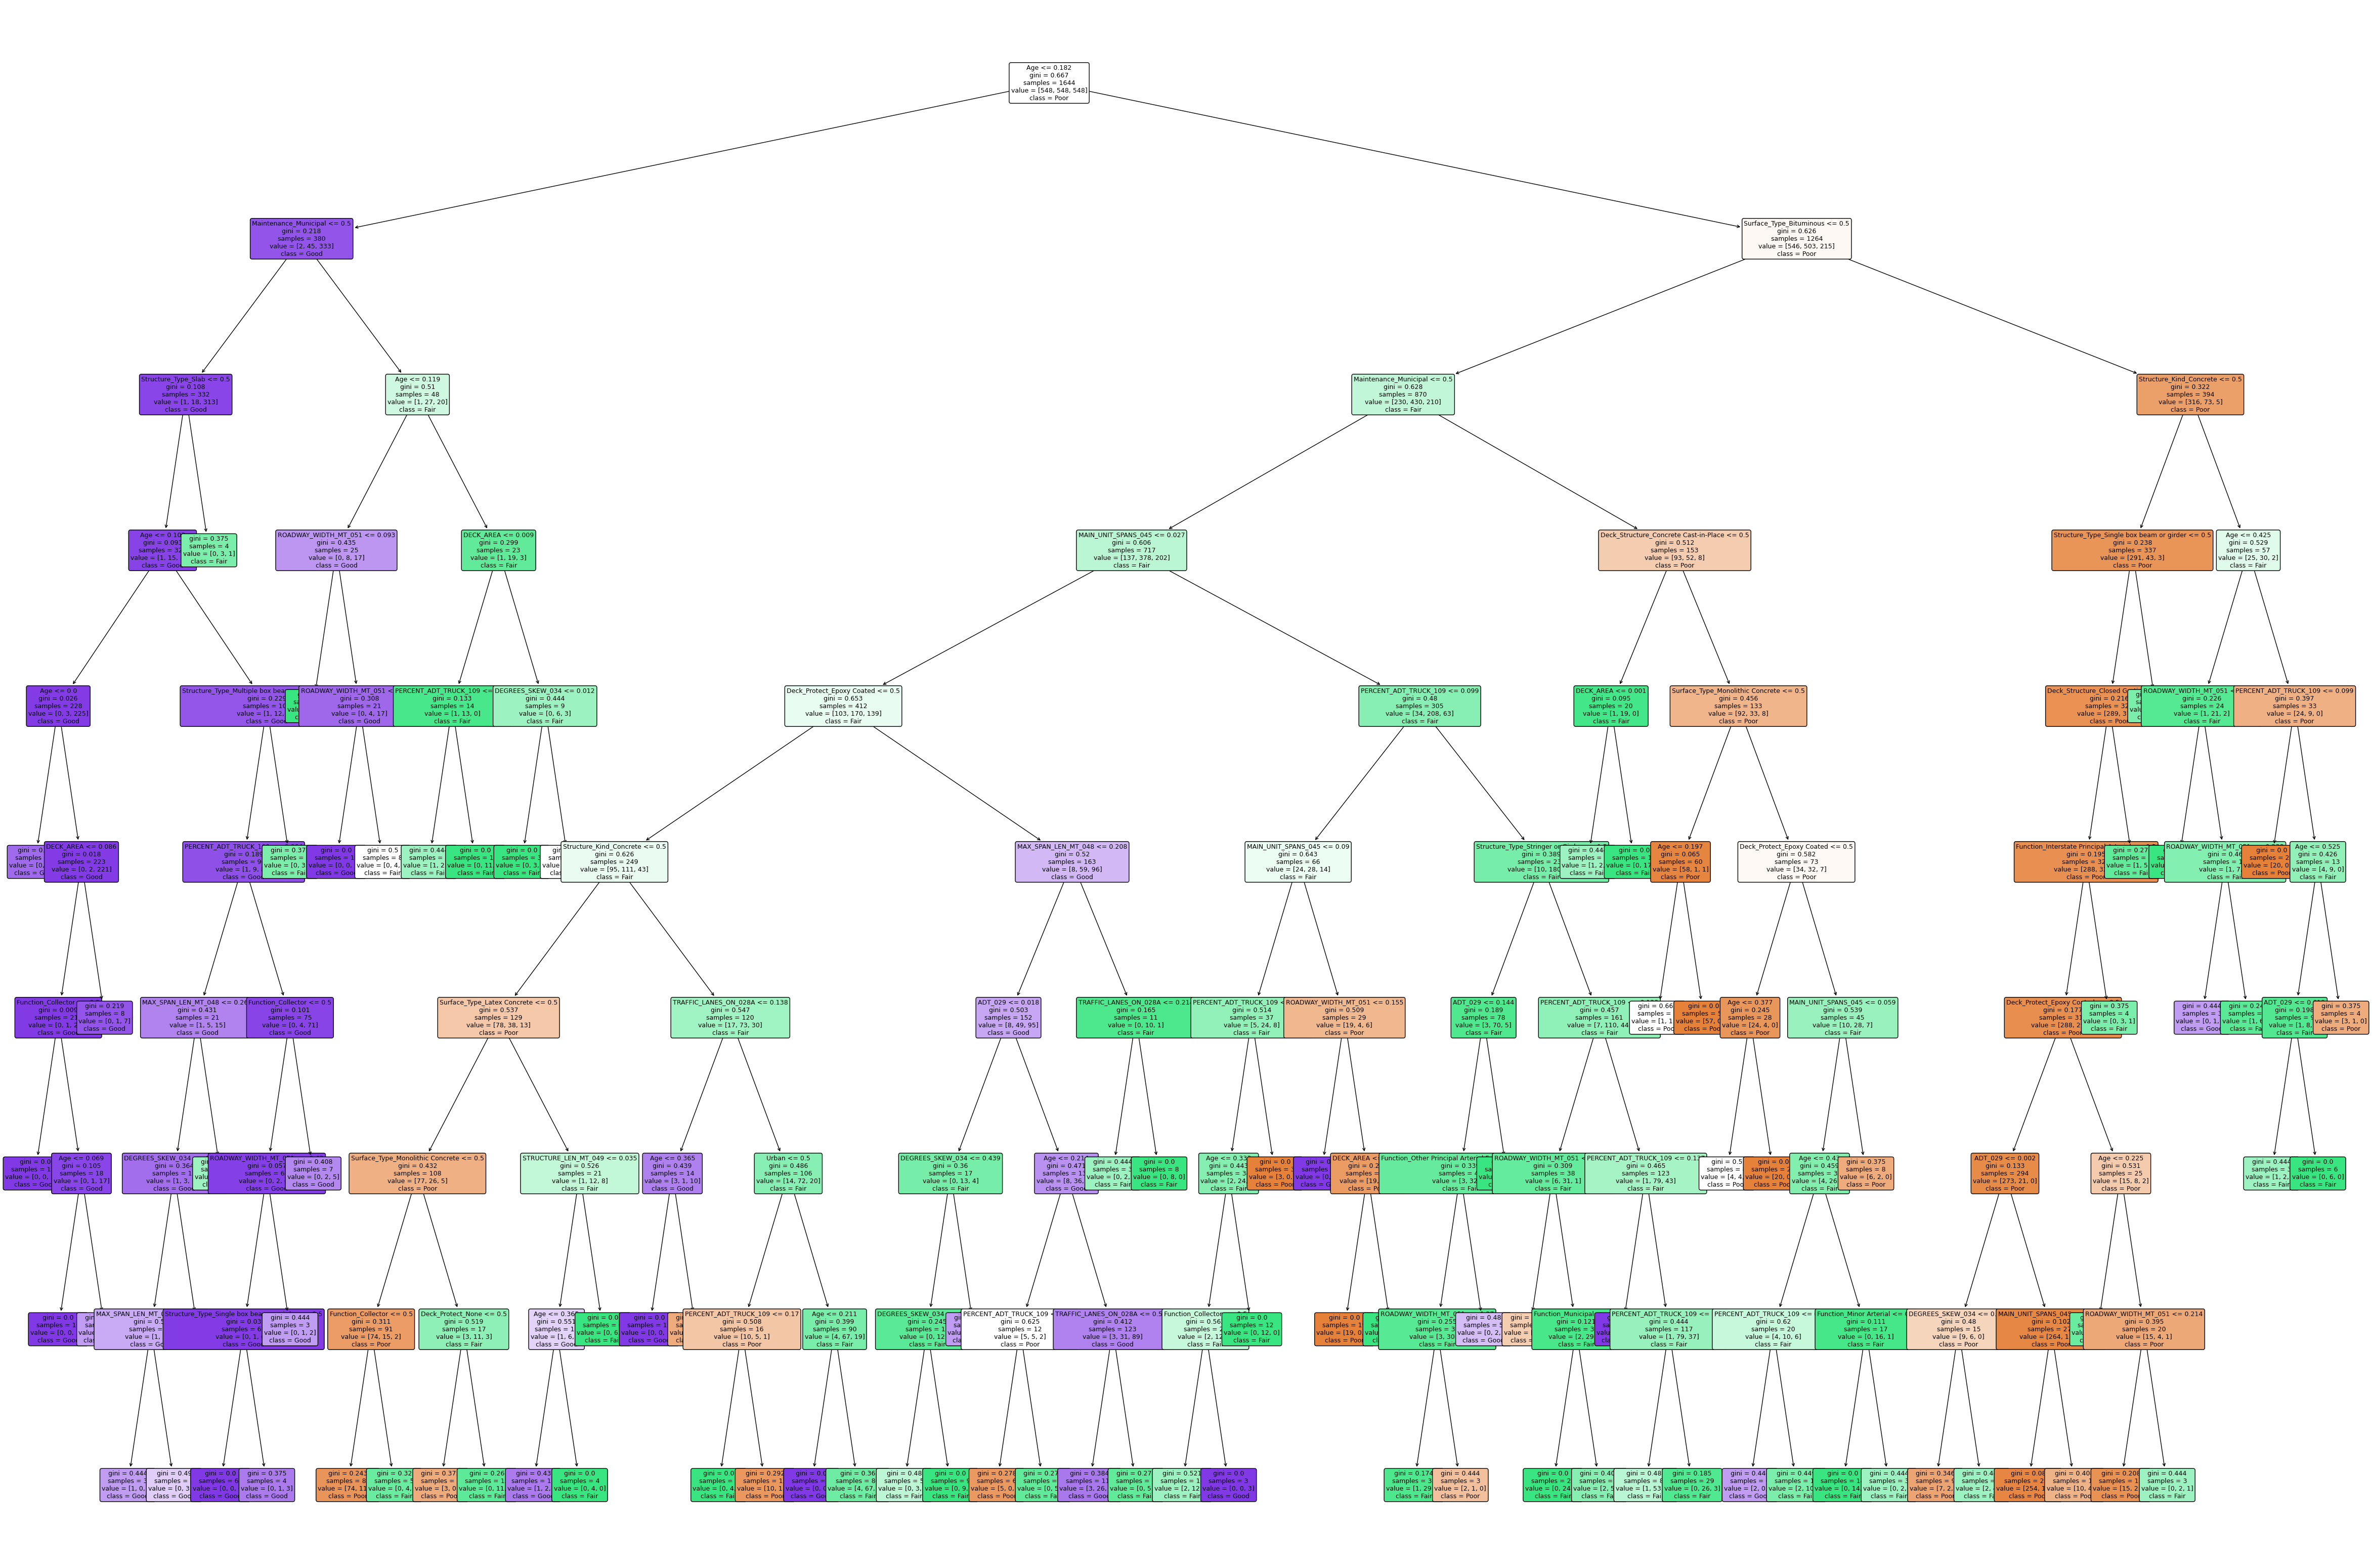

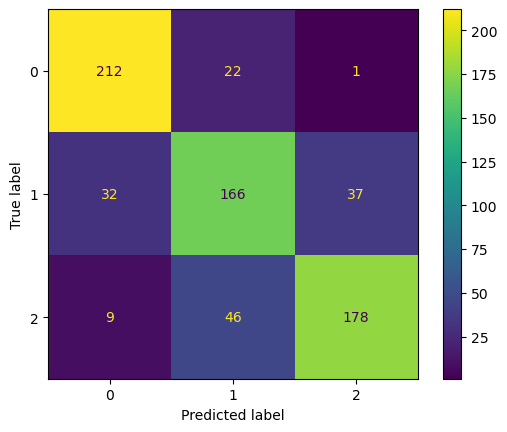

In [168]:
evaluate_CART(df)

## 3.3 Logistic Regression

In [169]:
def evaluate_logisticregression(df):
    X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.30,
                                                    random_state=1)
    logbridge = LogisticRegression()
    logbridge.fit(X_train, y_train)
    y_pred = logbridge.predict(X_test)
    #print(y_pred)
    lr_accuracy = accuracy_score(y_test, y_pred)
    print('Logistic Regression Accuracy of Scikit Model: {:.3f}%'.format(lr_accuracy*100))
    cm_bridge = confusion_matrix(y_test,y_pred)
    #print(cm_bridge)
    print(classification_report(y_test, y_pred, digits=3))
    display_cm_bridge= ConfusionMatrixDisplay(confusion_matrix=cm_bridge, 
                                              display_labels=['Poor (0)',
                                                              'Fair (1)',
                                                             'Good (2)'])
    display_cm_bridge.plot()
    
#Should we add cross-validation to this?

Logistic Regression Accuracy of Scikit Model: 78.805%
              precision    recall  f1-score   support

           0      0.895     0.902     0.898       235
           1      0.720     0.689     0.704       235
           2      0.747     0.773     0.759       233

    accuracy                          0.788       703
   macro avg      0.787     0.788     0.787       703
weighted avg      0.787     0.788     0.787       703



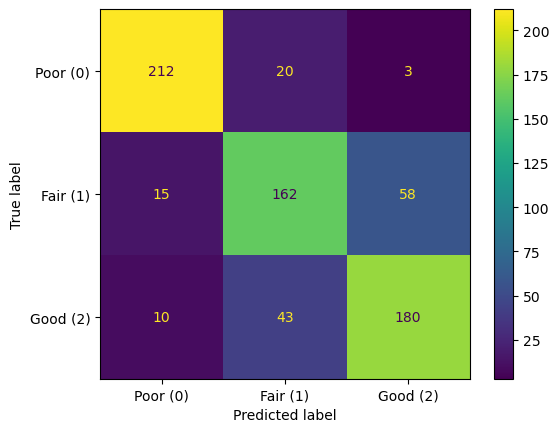

In [170]:
evaluate_logisticregression(df)

Our accuracy is slightly worse than the CART model, but not by much, suggesting that the logistic regression is an okay fit at predicting bridge condition. We can see that the model is much worse at predicting poor bridge conditions that fair or good conditions, likely a result of the amount of data we have on poor bridges. 